In [1]:
import astropy_healpix as ah
import healpy as hp

In [148]:
level=3
nsid=ah.level_to_nside(level)
pos=[ah.healpix_to_lonlat(i, nsid, order='ring') for i in range(hp.nside2npix(nsid))]
#pos2=[ah.healpix_to_lonlat(i, ah.level_to_nside(level+2), order='nested') for i in range(hp.nside2npix(level+2))]
import astropy.coordinates as coor
import astropy.units as u
#satel=coor.EarthLocation(lon=y['longitude']*u.deg,lat=y['latitude']*u.deg,height=y['altitude']*u.km)
ptsall=[coor.SkyCoord(ra,dec,frame='icrs') for ra,dec in pos]

#ptsall2=[coor.SkyCoord(ra,dec,frame='icrs') for ra,dec in pos2]

In [106]:
nadir=coor.AltAz(az=10*u.deg,alt=-90*u.deg,obstime=st,location=satel)

In [111]:
alts=[180-pt.separation(nadir).degree for pt in ptsall]

In [129]:
eloc2cart=lambda k: np.array([k.x.value,k.y.value,k.z.value])
nadir_cart=eloc2cart(coor.SkyCoord(nadir).transform_to('icrs').cartesian)

In [151]:
pts_cart=np.array([eloc2cart(pt1.cartesian) for pt1 in ptsall])

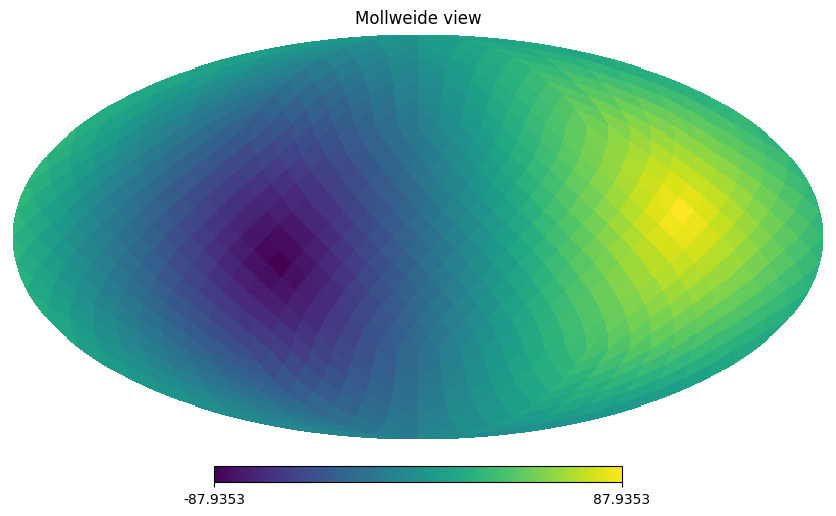

In [155]:
alts=np.arccos(pts_cart@nadir_cart)*180/np.pi-90


In [10]:
p=pos[0]
tle= """GRBALPHA                
1 47959U 21022AD  23003.09830623  .00006915  00000+0  43244-3 0  9990
2 47959  97.5131 263.5204 0019558 177.6055 288.4221 15.09580186 96918"""
qth=(48.7408, -21.2284, 380)
from datetime import datetime
st=datetime(2023,10,10,0,0,0)
import predict
y=predict.observe(tle, qth, at=st.timestamp())
y['altitude']

544.5485377444238

In [156]:
from datetime import timedelta
altall=[]
posel=[]
for d in range(0,1300):
    act=st+timedelta(0,d*60)
    y=predict.observe(tle, qth, at=act.timestamp())
    nadir=coor.AltAz(az=10*u.deg,alt=-90*u.deg,obstime=act,location=satel)
    nadir_cart=eloc2cart(coor.SkyCoord(nadir).transform_to('icrs').cartesian)
    #satel=coor.EarthLocation(lon=y['longitude']*u.deg,lat=y['latitude']*u.deg,height=y['altitude']*u.km)
    posel.append([y['longitude'],y['latitude']])
    #mp1=[]
    #for pt1 in ptsall:#[::10]:
    #    pt1.obstime=act
    #    pt1.location=satel
    #    mp1.append(pt1.altaz.alt.degree)
    altall.append(np.arccos(pts_cart@nadir_cart)*180/np.pi-90)
#altsel=np.array(altsel)
altall=np.array(altall)

(array([  1.,   0.,   3.,  22.,  95., 142., 118., 146., 125.,  61.,  18.,
          9.,  13.,   0.,   0.,   3.,   0.,   0.,   0.,  12.]),
 array([0.28615385, 0.32184615, 0.35753846, 0.39323077, 0.42892308,
        0.46461538, 0.50030769, 0.536     , 0.57169231, 0.60738462,
        0.64307692, 0.67876923, 0.71446154, 0.75015385, 0.78584615,
        0.82153846, 0.85723077, 0.89292308, 0.92861538, 0.96430769,
        1.        ]),
 <BarContainer object of 20 artists>)

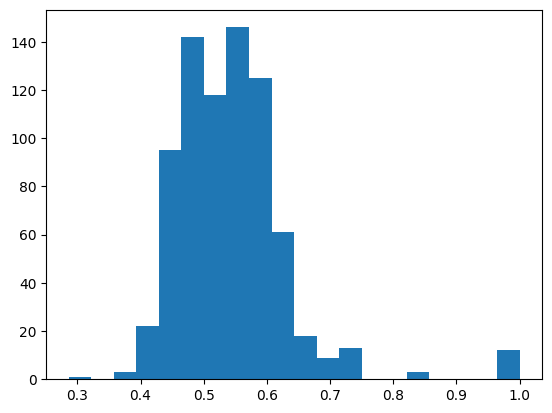

In [158]:
pl.hist(np.sum(altall>-5,0)/1300,20)

139

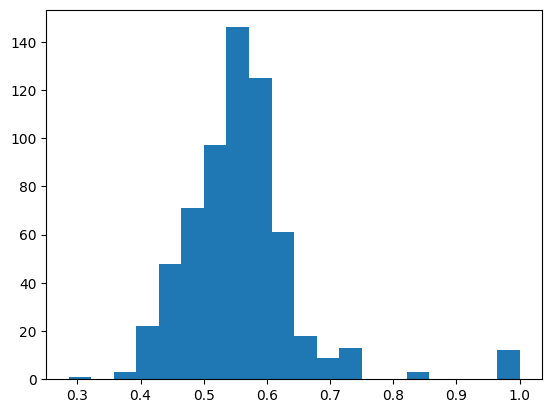

In [175]:
from astropy.time import Time
scor,mcor=coor.get_sun(Time(st)),coor.get_moon(Time(st))
sundist=np.arccos(pts_cart@eloc2cart(scor.cartesian))*180/np.pi
moondist=np.arccos(pts_cart@eloc2cart(mcor.cartesian))*180/np.pi

sel=(sundist>50)*(moondist>20)
pl.hist(np.sum(altall[:,sel]>-5,0)/1300,20)
len(np.where(sel==False)[0])

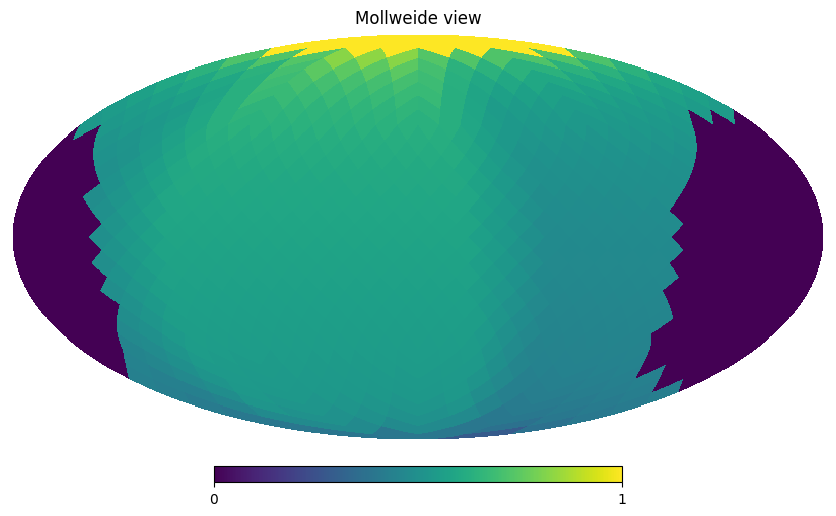

In [181]:
#sunclose2
rate=np.sum(altall>-5,0)/len(altall)
rate[sel==False]=0
hp.mollview(rate)
#hp.mollview(np.sum(altall[:,sel]>-5,0)/sum(sel))

In [182]:
altall1=[]
altall2=[]
for dd in range(30):
    stx=st+timedelta(dd,0)
    scor,mcor=coor.get_sun(Time(stx)),coor.get_moon(Time(stx))
    sundist=np.arccos(pts_cart@eloc2cart(scor.cartesian))*180/np.pi
    moondist=np.arccos(pts_cart@eloc2cart(mcor.cartesian))*180/np.pi
    sel=(sundist>50)*(moondist>20)
    altsel=[]
    for d in range(0,24*60):
        act=stx+timedelta(0,d*60)
        y=predict.observe(tle, qth, at=act.timestamp())
        nadir=coor.AltAz(az=10*u.deg,alt=-90*u.deg,obstime=act,location=satel)
        nadir_cart=eloc2cart(coor.SkyCoord(nadir).transform_to('icrs').cartesian)
        altsel.append(90-np.arccos(pts_cart@nadir_cart)*180/np.pi)
    altsel=np.array(altsel)
    altall1.append(np.sum(altall>-5,0)/(24*60))
    altall2.append(np.sum(altall[:,sel]>-5,0)/(24*60))
#altsel=np.array(altsel)
altall1=np.array(altall1)
altall2=np.array(altall2)

/tmp/ipykernel_107760/917291959.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  altall2=np.array(altall2)


In [193]:
objsel=[]
for dd in range(30):
    stx=st+timedelta(dd,0)
    scor,mcor=coor.get_sun(Time(stx)),coor.get_moon(Time(stx))
    sundist=np.arccos(pts_cart@eloc2cart(scor.cartesian))*180/np.pi
    moondist=np.arccos(pts_cart@eloc2cart(mcor.cartesian))*180/np.pi
    objsel.append((sundist>50)*(moondist>20))
objsel=np.array(objsel)

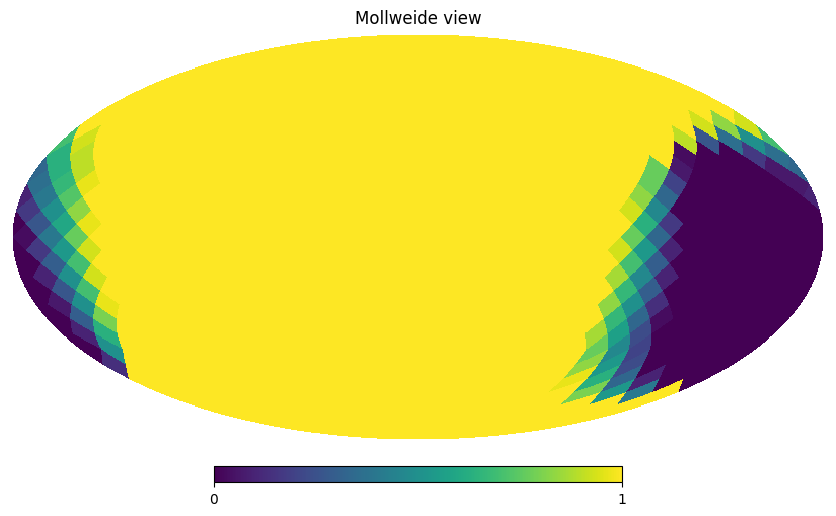

In [194]:
hp.mollview(objsel.mean(0))

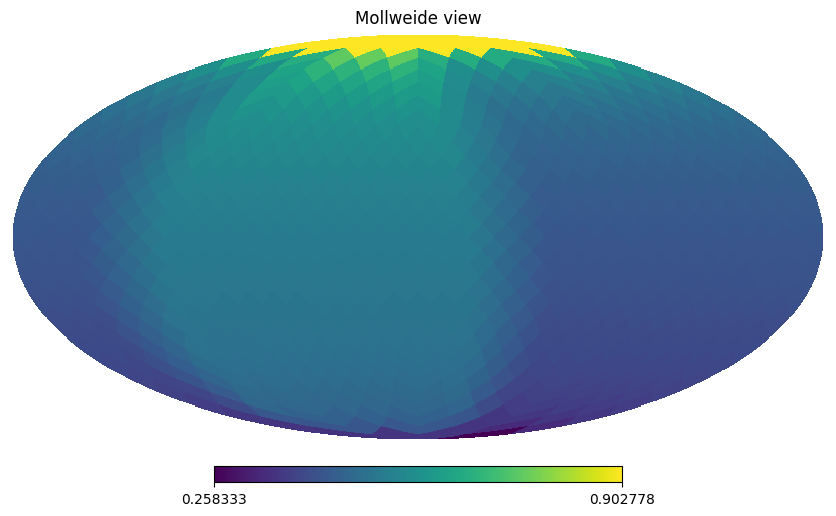

In [195]:
hp.mollview(altall1.mean(0))

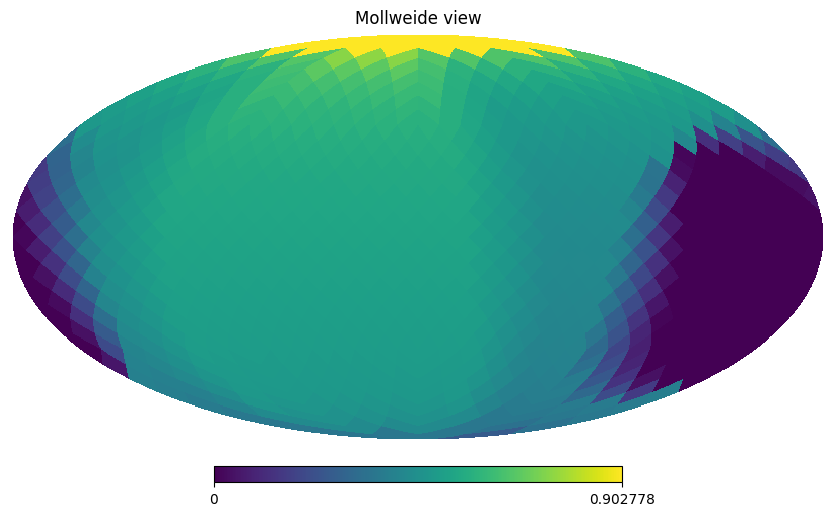

In [196]:
hp.mollview((altall1*objsel).mean(0))

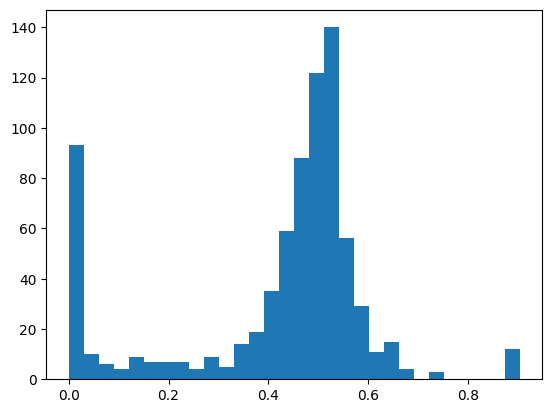

In [197]:
pl.hist((altall1*objsel).mean(0),30);

In [1]:
from matplotlib import pyplot as pl
pl.hist((altall>0).sum(0)/1300,20,alpha=0.3)
pl.hist((altall>-5).sum(0)/1300,20,alpha=0.3)
pl.hist((altall>-10).sum(0)/1300,20,alpha=0.3);

NameError: name 'altall' is not defined

In [199]:
np.save("coverage",altall2,)

